# Naural Networks

## Załadowanie i przygotowanie danych

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import keras
import tensorflow
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

komentarz

In [15]:
chess = pd.read_csv("Data/games.csv")
chess = chess.loc[:4999, :]
chess.drop(columns=['created_at', 'last_move_at', 'victory_status', 'white_id', 'black_id', 'moves', 'opening_eco', 'opening_name', 'id'], inplace=True)
chess.head()

,rated,turns,winner,increment_code,white_rating,black_rating,opening_ply
0,False,13,white,15+2,1500,1191,5
1,True,16,black,5+10,1322,1261,4
2,True,61,white,5+10,1496,1500,3
3,True,61,white,20+0,1439,1454,3
4,True,95,white,30+3,1523,1469,5


In [16]:
chess.loc[:, 'rated'] = chess.loc[:, 'rated']*1

Zakodowanie wartości kategorycznych

In [17]:
temp = pd.get_dummies(chess.loc[:, ['increment_code']])
chess.drop(columns=['increment_code'], inplace=True)

In [18]:
chess = pd.concat([chess, temp], axis=1)
chess.replace({np.nan, 0})

,rated,turns,winner,white_rating,black_rating,opening_ply,increment_code_0+15,increment_code_0+25,increment_code_1+10,increment_code_1+12,...,increment_code_9+10,increment_code_9+12,increment_code_9+2,increment_code_9+20,increment_code_9+3,increment_code_9+5,increment_code_9+9,increment_code_90+0,increment_code_90+120,increment_code_90+30
0,0,13,white,1500,1191,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,black,1322,1261,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,white,1496,1500,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,white,1439,1454,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,white,1523,1469,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,57,white,2220,2157,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,45,white,2157,1380,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,109,white,2157,1569,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,45,white,2157,2000,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
chess.loc[:, ['rated', 'turns', 'white_rating', 'black_rating', 'opening_ply']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   rated         5000 non-null   int64
 1   turns         5000 non-null   int64
 2   white_rating  5000 non-null   int64
 3   black_rating  5000 non-null   int64
 4   opening_ply   5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


## Tworzenie modelu

Artykuł o tworzeniu modelu: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

## Próba przewidzenie czy wygra biały, czarny czy spotkanie zakończy się remisem

Podział na zmienne objąśniające i objaśnianą

In [22]:
X = chess.drop(columns=['winner'])
y = chess.loc[:, 'winner'].replace({"white": 1, "draw": 0, "black": -1})

Przedstawienie na wykresie liczby wygranych białych, czarnych oraz remisów

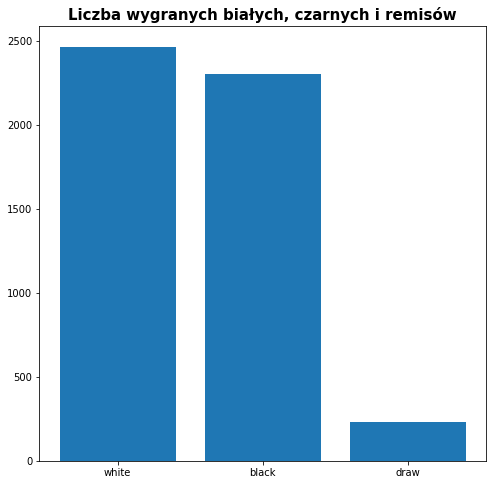

In [42]:
labels = chess.loc[:, "winner"].value_counts().index
values = chess.loc[:, "winner"].value_counts().values
plt.figure(figsize=(8, 8))
plt.bar(labels, values, align="center")
plt.title("Liczba wygranych białych, czarnych i remisów", fontdict={"fontweight": "bold", "size": 15})
plt.show()

Podział na zbiór uczący i testowy w stosunku 80/20

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Tworzenie początkowego modelu z jedną warstwą wejściową, jedną ukrytą, oraz jedną wyjściową. Tworzony model będzie typu Sekwencyjnego, czyli do modelu dodajemy kolejne warstwy neuronowe, z wybranymi przez nasa parametrami.

In [57]:
X_train.shape

(4000, 214)

In [61]:
model = Sequential()
model.add(Dense(units=16, input_dim=214, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))

Optymalizacja modelu do uczenia przy uzyciu adaptującego optymalizera Adam

In [64]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Fitowanie modelu

In [91]:
y_train = y_train.values.reshape(-1)
X_train = X_train.values
print(X_train)
print(y_train)
model.fit(X_train, y_train, epochs=20, batch_size=100)

[[   1   94 1719 ...    0    0    0]
 [   1   44 1587 ...    0    0    0]
 [   1   17 1442 ...    0    0    0]
 ...
 [   1    9 1570 ...    0    0    0]
 [   1   34 1796 ...    0    0    0]
 [   1   73 1409 ...    0    0    0]]
[-1 -1  1 ...  1 -1  1]
Epoch 1/20


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (100, 1) and (100, 3) are incompatible


Artykuł o optymalizacji: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

Artykuł o funkcjach aktywacyjnych: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

## Próba przewidzenie czy wygra biały
